In [25]:
import json
import re
import os
import gzip
import numbers
import numpy as np
import pandas as pd
import platform
import multiprocessing as mp
from functools import partial
import seaborn as sns
import matplotlib as mpl
from IPython.display import display, HTML
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta as td

spectra_map = {0: 'M', 1: 'K', 2: 'G', 3: 'F', 4: 'A', 5: 'B', 6: 'O', 7: 'X'}
singularity_flags = {
    'TidalLocked': 1,
    'TidalLocked2': 2,
    'TidalLocked4': 4,
    'LaySide': 8,
    'ClockwiseRotate': 16,
    'MultipleSatellites': 32,
}
star_type_map = {
    0: 'Main Sequence',
    1: 'Giant',
    2: 'White Dwarf',
    3: 'Neutron Star',
    4: 'Black Hole',
}
vein_type_map = {'verbose': {
    'Iron': 'Iron', 'Copper': 'Copper', 'Silicium': 'Silicon', 'Titanium': 'Titanium', 
    'Stone': 'Stone', 'Coal': 'Coal', 'Oil' : 'Oil', 'Fireice': 'Fire ice', 'Diamond': 'Kimberlite',
    'Fractal': 'Fractal Silicon', 'Crysrub': 'Organic Crystal', 'Grat': 'Optical Grating', 
    'Bamboo': 'Spiniform Stalagmite Crystal', 'Mag': 'Unipolar Magnets', },
                 'terse': {
    'Iron': 'Iron', 'Copper': 'Copper', 'Silicium': 'Silicon', 'Titanium': 'Titanium', 
    'Stone': 'Stone', 'Coal': 'Coal', 'Oil' : 'Oil', 'Fireice': 'Fire ice', 'Diamond': 'Kimber.',
    'Fractal': 'Fractal Silicon', 'Crysrub': 'Organic Crystal', 'Grat': 'Optical Grating', 
    'Bamboo': 'Spin. Stal. Crystal', 'Mag': 'Uni. Magnets', }
}['terse']
vein_types = list(vein_type_map.values())
ocean_types = ['Water', 'Sulfuric acid']
base_types = ['Iron', 'Copper', 'Silicon', 'Titanium', 'Stone', 'Coal']
gas_types = ['Hydrogen gas', 'Deuterium gas', 'Fire ice gas',]
S_scaled = gas_types + ['Oil']
M_scaled = [x for x in vein_types if x not in S_scaled]

previous_runs = [
    84459701, 16015752, 22778246, 26027001, 57786559, 51279269, 94520636, 
    32680784, 88834638, 22161804, 87759803, 76768927, 18238299, 43378616,
    84459702, 91684768, 82451776, 31106147, 68258881,
]

In [2]:
export_path = {
    # original Windows location
    'Chonyi': '/mnt/c/' + r'\Users\Drake\Documents\Dyson Sphere Program\dsp_seedexporter'.replace('\\', '/'),
    
    # NTFS mount in Linux
    'chonyi': '/media/drake/Windows/Users/Drake/Documents/Dyson Sphere Program/dsp_seedexporter/',
    # copied into shared library
    # 'chonyi': os.path.expanduser('~/data/dsp/seeds'),
    
    # copied from Chonyi
    'blincoln': os.path.expanduser('~/data/dsp/seeds'),
    'megalith': os.path.expanduser('~/data/dsp/seeds'),
}[platform.node()]
seed_re = re.compile(r'seed_(?P<seed>\d{8}).json.gz')

In [3]:
files = sorted(filter(seed_re.match, os.listdir(export_path)))
seeds = list(map(lambda x: int(seed_re.match(x).group('seed')), files))
print('{:d} files detected'.format(len(files)))

13386 files detected


In [4]:
def process_universe(func, filename):
    file = os.path.join(export_path, filename)
    try:
        with gzip.GzipFile(file, mode='r') as fd:
            universe = json.load(fd)
            universe['meta']['mtime'] = dt.fromtimestamp(os.stat(file).st_mtime)
    except EOFError as e:
        raise ValueError('Bad file: ' + file)
    return func(universe)

def passthrough(x):
    return x

subset = ['seed_18238299.json.gz', 'seed_94520636.json.gz', 'seed_94520637.json.gz']
with mp.Pool(mp.cpu_count() - 1) as pool:
    universes = pool.map(partial(process_universe, passthrough), subset, chunksize=100)
universe = universes[0]

In [5]:
def distance(star):
    return sum(np.fromiter(star['position'].values(), dtype='float') ** 2) ** 0.5

distance_df = pd.DataFrame.from_records(
    data=[(star_name, distance(star)) for star_name, star in universe['star'].items()], 
    columns=['star_name', 'abs. dist.']
).sort_values('abs. dist.')
distance_df

,star_name,abs. dist.
0,Procyon,0.000000
1,Tramontana,2.960353
16,Zeta Arietis,4.005012
17,27 Ophiuchii,4.611032
4,Lambda Sagittae,5.189216
...,...,...
40,ζ Chamaeleontis,27.360977
45,Cymbae,30.245616
51,Theta Puppis,33.166251
60,Arided,36.442384


In [6]:
home_star = distance_df.iloc[0]
assert home_star['abs. dist.'] == 0.
home_system = universe['star'][home_star['star_name']]

In [7]:
def map_strings(universe):
    planet_types = []
    star_types = []
    singularities = []
    planet_count = 0
    for star in universe['star'].values():
        try:
            star_types.append((star['type'], star['typeString']))
        except KeyError:
            pass
        for planet in star['planet'].values():
            try:
                singularities.append((planet['singularity'], planet['singularityString']))
            except KeyError:
                pass
            try:
                planet_types.append((planet['type'], planet['typeString']))
            except KeyError:
                pass
            planet_count += 1
    return (
        np.unique(planet_types, axis=0), 
        np.unique(singularities, axis=0), 
        np.unique(star_types, axis=0), 
        planet_count
    )


with mp.Pool(mp.cpu_count() - 1) as pool:
    planet_types, singularities, star_types, planet_count = zip(*pool.imap_unordered(partial(process_universe, map_strings), files, chunksize=100))
planet_types = np.unique(np.concatenate([x for x in planet_types if len(x) > 0]), axis=0)
singularities = np.unique(np.concatenate([x for x in singularities if len(x) > 0]), axis=0)
star_types = np.unique(np.concatenate([x for x in star_types if len(x) > 0]), axis=0)


In [8]:
display(pd.DataFrame.from_records(planet_types, columns=['code', 'type']))
display(pd.DataFrame.from_records(star_types, columns=['code', 'type']))

,code,type
0,1,Lava
1,1,Volcanic Ash
2,2,Mediterranean
3,2,Oceanic Jungle
4,2,Prairie
5,2,Red Stone
6,2,Sakura Ocean
7,2,Waterworld
8,3,Arid Desert
9,3,Ashen Gelisol


,code,type
0,0,A type star
1,0,B type star
2,0,F type star
3,0,G type star
4,0,K type star
5,0,M type star
6,0,O type star
7,1,Blue giant
8,1,Red giant
9,1,White giant


In [9]:
OIL_SPEED_MULTIPLIER = 4e-5
DYSON_SPHERE_BUFFER = 1.35

def reorder(df):
    resource_cols = vein_types + gas_types
    first_cols = [x for x in df.columns if x not in resource_cols]
    df[resource_cols] = df[resource_cols].fillna(0)
    return df[first_cols + resource_cols]

def scan_systems(universe):
    home_star_id = universe['meta']['birthStarId']
    home_planet_id = universe['meta']['birthPlanetId']
    seed = universe['meta']['seed']
    mtime = universe['meta']['mtime']
    stars = []
    planets = []
    
    for star in universe['star'].values():
        max_dyson_rad = star['dysonRadius'] * 2

        star_dict = {
            'seed': seed,
            'star': star['name'],
            'home_system': star['id'] == home_star_id,
            'spectrum': spectra_map[star['spectr']],
            'type': star_type_map[star['type']],
            'luminosity': star['luminosity'],
        }
        stars.append(star_dict)

        for planet in star['planet'].values():
            planet_dict = {
                'seed': seed,
                'star': star['name'],
                'planet': planet['name'],
                'home_system': star['id'] == home_star_id,
                'homeworld': planet['id'] == home_planet_id,
                'type': planet.get('typeString', None),
                'tidal_lock': (planet['singularity'] & singularity_flags['TidalLocked']) > 0,
                'in_sphere': planet['sunDistance'] <= max_dyson_rad / DYSON_SPHERE_BUFFER,
                'ocean': planet.get('waterItem', None),
                'landPercent': planet.get('landPercent', 0.),
            }
            if 'vein' in planet:
                planet_veins = {vein_type_map[k]: v for k, v in planet['vein'].items()}
            elif 'gas' in planet:
                planet_veins = {(k + ' gas'): float(v['gasSpeed']) for k,v in planet['gas'].items()}
            else:
                raise ValueError('Bad planet: {}'.format(planet['name']))
            assert all(isinstance(x, (int, float)) for x in planet_veins.values()), planet_veins
            planets.append({**planet_dict, **planet_veins})
            
    planet_df = pd.DataFrame.from_records(planets)
    planet_df['Oil'] *= OIL_SPEED_MULTIPLIER
    
    star_df = pd.DataFrame.from_records(stars)
    systems = planet_df.groupby('star')
    star_resources = systems.sum(numeric_only=True).reindex(vein_types + gas_types, axis='columns')
    star_resources['planets'] = systems['planet'].count()
    oceans = (systems['ocean'].value_counts().unstack() > 0)[['Water', 'Sulfuric acid']]
    oceans.reindex(star_df['star'], fill_value=False)
    star_df = (star_df
               .merge(star_resources, left_on='star', right_index=True, validate='1:1')
               .merge(oceans.reindex(star_df['star'], fill_value=False), 
                      left_on='star', right_index=True, validate='1:1'))
    
    seed_df =  pd.DataFrame.from_records([{'seed': seed, 'ts': mtime}])
    
    return star_df, planet_df, seed_df

star_df, planet_df, seed_df = scan_systems(universe)
display(star_df.head())
display(planet_df.head())
display(seed_df.head())

,seed,star,home_system,spectrum,type,luminosity,Iron,Copper,Silicon,Titanium,...,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas,planets,Water,Sulfuric acid
0,18238299,Procyon,True,G,Main Sequence,0.978408,23539812.0,33240354.0,13467962.0,13893383.0,...,0.0,0.0,0.0,0.0,0.250872,0.0,0.597154,4,True,False
1,18238299,Tramontana,False,M,Main Sequence,0.583942,14053173.0,28310788.0,3529581.0,37695658.0,...,0.0,2664609.0,0.0,0.0,0.000000,0.0,0.000000,3,True,False
2,18238299,Gamma Vulpeculae,False,K,Main Sequence,0.823254,36914259.0,41160402.0,20979566.0,37358159.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,3,True,False
3,18238299,YedPrior,False,M,Main Sequence,0.497194,26414756.0,18726224.0,19573996.0,39492924.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,3,True,False
4,18238299,Lambda Sagittae,False,K,Main Sequence,0.817663,9531719.0,1975948.0,4960219.0,31078570.0,...,0.0,958814.0,0.0,0.0,0.000000,0.0,0.000000,2,True,False


,seed,star,planet,home_system,homeworld,type,tidal_lock,in_sphere,ocean,landPercent,...,Hydrogen gas,Oil,Fire ice,Fractal Silicon,Optical Grating,Spin. Stal. Crystal,Kimber.,Organic Crystal,Deuterium gas,Uni. Magnets
0,18238299,Procyon,Procyon I,True,False,Lava,False,True,None,0.873394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18238299,Procyon,Procyon II,True,False,Gobi,False,False,None,0.989456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18238299,Procyon,Procyon III,True,False,Ice Giant,False,False,None,0.000000,...,0.250872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18238299,Procyon,Procyon IV,True,True,Mediterranean,False,False,Water,0.601668,...,NaN,53.22388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18238299,Tramontana,Tramontana I,False,False,Arid Desert,False,True,None,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,seed,ts
0,18238299,2021-09-07 18:25:41.524348


In [10]:
with mp.Pool(mp.cpu_count() - 1) as pool:
    star_dfs, planet_dfs, seed_dfs = zip(*pool.imap_unordered(partial(process_universe, scan_systems), files, chunksize=100))
star_df = reorder(pd.concat(star_dfs))
planet_df = reorder(pd.concat(planet_dfs))
seed_df = pd.concat(seed_dfs)

In [11]:
home_systems = star_df.query('home_system == True').copy()
home_systems.head()

,seed,star,home_system,spectrum,type,luminosity,planets,Water,Sulfuric acid,Iron,...,Fire ice,Kimber.,Fractal Silicon,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas
0,4887201,Gamma Sagittarii,True,G,Main Sequence,1.038123,4,True,False,25177102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273024,0.000000,0.583940
0,4894185,HyadumPrimus,True,G,Main Sequence,0.956260,4,True,False,24430580.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282370,0.000000,0.659612
0,4901009,Aldhibain,True,G,Main Sequence,1.039716,4,True,False,30146545.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275892,0.000000,0.655810
0,4907316,Algorab,True,G,Main Sequence,1.017187,4,True,False,23697559.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875934,0.031518,0.000000
0,4921057,Ancha,True,G,Main Sequence,1.035826,4,True,False,13020677.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.894733,0.031427,0.000000


In [12]:
home_system_planets = planet_df.query('home_system == True').copy()
home_system_planets.head()

,seed,star,planet,home_system,homeworld,type,tidal_lock,in_sphere,ocean,landPercent,...,Fire ice,Kimber.,Fractal Silicon,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas
0,4887201,Gamma Sagittarii,Gamma Sagittarii I,True,False,Lava,False,True,None,0.855301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
1,4887201,Gamma Sagittarii,Gamma Sagittarii II,True,False,Ice Giant,False,False,None,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273024,0.0,0.58394
2,4887201,Gamma Sagittarii,Gamma Sagittarii III,True,True,Mediterranean,False,False,Water,0.637212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
3,4887201,Gamma Sagittarii,Gamma Sagittarii IV,True,False,Gobi,False,False,None,0.992352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
0,4894185,HyadumPrimus,HyadumPrimus I,True,False,Lava,False,True,None,0.844534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000


In [13]:
home_system_planets['TL|IS'] = home_system_planets['tidal_lock'] | home_system_planets['in_sphere']
home_system_planets['TL&IS'] = home_system_planets['tidal_lock'] & home_system_planets['in_sphere']
tl_is = home_system_planets.groupby(['seed', 'star'])[['TL|IS', 'TL&IS', 'tidal_lock', 'in_sphere']].sum()
pd.DataFrame({col: tl_is.reset_index().groupby(col)['star'].count()
              for col in tl_is.columns}).fillna(0).astype(int)

,TL|IS,TL&IS,tidal_lock,in_sphere
0,5498,13085,12773,5646
1,7716,301,605,7740
2,172,0,8,0


In [14]:
homeworlds = home_system_planets.query('homeworld == True')
landmass = homeworlds[['seed', 'landPercent']].rename(columns={'landPercent': 'land'})

In [15]:
res_df = star_df.copy()
res_df[vein_types + gas_types] = res_df[vein_types + gas_types] > 0
res_probs = res_df.groupby(['spectrum', 'type'])[ocean_types
                                                 + vein_types 
                                                 + gas_types
                                                ].mean()
res = 'Organic Crystal'
res_probs.loc[res_probs[res] > 0].sort_values(res, ascending=False).style.format(precision=2)

,,Water,Sulfuric acid,Iron,Copper,Silicon,Titanium,Stone,Coal,Oil,Fire ice,Kimber.,Fractal Silicon,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas
spectrum,type,,,,,,,,,,,,,,,,,,,
F,Main Sequence,0.79,0.39,1.00,1.00,1.00,1.00,1.00,1.00,0.54,0.69,0.31,0.21,0.44,0.18,0.26,0.00,0.46,0.26,0.20
G,Main Sequence,0.85,0.29,1.00,1.00,1.00,0.99,1.00,1.00,0.59,0.69,0.30,0.21,0.42,0.19,0.28,0.00,0.46,0.26,0.20
K,Main Sequence,0.85,0.18,0.99,0.99,0.98,0.96,0.99,0.99,0.50,0.79,0.31,0.27,0.41,0.23,0.31,0.00,0.31,0.18,0.14
M,Main Sequence,0.88,0.10,0.99,0.99,0.98,0.97,0.99,0.99,0.43,0.89,0.46,0.50,0.35,0.43,0.37,0.00,0.31,0.17,0.13
A,Main Sequence,0.54,0.53,1.00,1.00,1.00,1.00,1.00,1.00,0.29,0.56,0.50,0.33,0.23,0.30,0.17,0.00,0.53,0.31,0.24
B,Main Sequence,0.43,0.71,1.00,1.00,1.00,1.00,1.00,1.00,0.11,0.61,0.32,0.20,0.09,0.18,0.04,0.00,0.65,0.40,0.31
O,Main Sequence,0.39,0.83,1.00,1.00,1.00,1.00,1.00,1.00,0.11,0.71,0.79,0.59,0.09,0.57,0.08,0.00,0.68,0.43,0.34
M,Giant,0.01,0.37,1.00,1.00,0.94,0.94,1.00,1.00,0.01,0.00,0.46,0.30,0.01,0.25,0.01,0.00,0.54,0.30,0.24


In [16]:
def S_scaler(f):
    return '{:.2f}/s'.format(f)

def M_scaler(f):
    if f < 10e6:
        return '{:.1f}'.format(f / 1e6)
    else:
        return '{:.0f}'.format(f / 1e6)

def f2_scaler(f):
    return '{:.2f}'.format(f)
    
shaders = {
    'limit': M_scaler,
    'land': f2_scaler,
    **{col: S_scaler for col in S_scaled},
    **{col: M_scaler for col in M_scaled},
    **{col + ' (Start)': S_scaler for col in S_scaled},
    **{col + ' (Start)': M_scaler for col in M_scaled},
}
formatters = {**shaders,
    'ts': lambda x: x.strftime('%b-%d'),
    'rank': f2_scaler,
}

def shader(series, pct):
    pct_subset = pct.loc[series.index, series.name] ** (4/5)
    cmap = mpl.cm.get_cmap('coolwarm_r')
    rgb = [sns.set_hls_values(color=cmap(x), h=None, l=0.75, s=None) for x in pct_subset]
    return ['background: {};'.format(mpl.colors.rgb2hex(x)) for x in rgb]

def show(pct, df):
    shade_cols = [x for x in df.columns if x in shaders.keys()]
    display(HTML(
        df
        .style
        .apply(func=shader, pct=pct[shade_cols], axis='index', subset=shade_cols)
        .format(formatter=formatters)
        .to_html()
    ))

In [17]:
home_resources = home_systems.set_index('seed')[base_types + ['Oil', 'Fire ice', 'Fire ice gas']]
home_resources['limit'] =  home_resources[base_types].min(axis='columns')

seed_res = (
    tl_is.reset_index(level='star')
    .merge(seed_df, on='seed', validate='1:1')
    .merge(landmass, on='seed', validate='1:1')
    .merge(home_resources, on='seed', validate='1:1')
    .merge(
        star_df.groupby('seed')[ocean_types + vein_types + gas_types].sum(), 
        on='seed', validate='1:1', suffixes=[' (Start)', ''])
).set_index('seed')
seed_res.drop(columns=['TL|IS', 'TL&IS', 'ts', 'limit']).to_csv('seed_resources.csv', index=True)

In [26]:
recent = dt.now() - td(days=7)

potential = (
    seed_res
    .query('(`Fire ice (Start)` > 500e3) | ((`Fire ice (Start)` > 0) & (`Fire ice gas (Start)` > 0))')
    # .query('`ts` > @recent')
    # .query('`TL|IS` >= 1')
    .query('`tidal_lock` >= 1')
    # .query('limit > 6e6')
    # .query('`Organic Crystal` > 50e6')
    # .query('`land` > .6')
    
    # .sort_values('limit', ascending=False)
    # .sort_values('Organic Crystal', ascending=False)
    
    .drop(columns=['TL|IS', 'TL&IS'])
    .rename(columns={'tidal_lock': 'TL', 'in_sphere': 'IS'})
)

all_pct = seed_res.rank(pct=True, method='min').loc[potential.index]
potential_pct = potential.rank(pct=True, method='min')
rank_pct = potential_pct

rsrc_cols = vein_types + gas_types
start_rsrc_cols = [
    'Iron (Start)', 'Copper (Start)', 'Silicon (Start)', 'Titanium (Start)', 'Stone (Start)', 'Coal (Start)', 'Oil (Start)']
useful_rsrc_cols = [
    'Iron', 'Copper', 'Silicon', 'Titanium', 'Stone', 'Coal', 'Oil',
    'Organic Crystal', 'Hydrogen gas', 'Fire ice gas']


# rank_cols = ['land', 'limit'] + start_rsrc_cols + useful_rsrc_cols
rank_cols = ['land', 'limit'] + ['Silicon (Start)', 'Titanium (Start)', 'Oil (Start)']
# rank_cols = start_rsrc_cols + useful_rsrc_cols
# rank_cols = ['limit', 'Oil', 'Organic Crystal', 'Silicon (Start)', 'Oil (Start)']
# rank_cols = useful_rsrc_cols

sort_val = rank_pct[rank_cols].min(axis='columns')
# sort_val = rank_pct[rank_cols].quantile(0.15, axis='columns')
# sort_val = rank_pct[rank_cols].mean(axis='columns')

potential.insert(1, 'rank', sort_val)
sort_idx = sort_val.sort_values(ascending=False).index
potential = potential.loc[sort_idx]
pre_run = potential.index.isin(previous_runs)
show(rank_pct, potential.loc[pre_run])
show(rank_pct, potential.loc[~pre_run].head(15))


,star,rank,TL,IS,ts,land,Iron (Start),Copper (Start),Silicon (Start),Titanium (Start),Stone (Start),Coal (Start),Oil (Start),Fire ice (Start),Fire ice gas (Start),limit,Water,Sulfuric acid,Iron,Copper,Silicon,Titanium,Stone,Coal,Oil,Fire ice,Kimber.,Fractal Silicon,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas
seed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68258881,NairalZaurak,0.58,1,0,Sep-07,0.63,28,21,5.9,27,7.7,8.2,55.34/s,9.0,0.00/s,5.9,43,27,6214,8254,3508,6947,5554,975,2548.44/s,660,65,146,108,82,66,3.1,22.02/s,0.62/s,16.87/s
26027001,Maasym,0.44,1,1,Sep-07,0.60,28,23,6.0,27,10,9.2,52.71/s,19,0.65/s,6.0,43,31,4672,6191,2957,5649,4318,685,2234.22/s,579,83,97,58,67,67,18,15.96/s,0.33/s,19.52/s
91684768,Gamma Arae,0.38,1,1,Oct-13,0.62,30,22,6.3,26,8.4,8.7,47.68/s,1.5,0.00/s,6.3,40,27,4950,6177,2728,5770,4235,664,2219.23/s,655,83,97,58,62,42,14,26.58/s,2.06/s,11.27/s
84459702,Theemim,0.27,1,0,Sep-07,0.67,7.4,7.0,14,17,7.1,11,47.40/s,3.0,0.65/s,7.0,46,29,6018,7125,4117,7553,6425,855,2412.53/s,1388,250,373,101,161,82,20,30.48/s,1.00/s,15.43/s
43378616,Alkaphrah,0.21,1,1,Sep-10,0.60,28,21,12,18,11,9.3,47.21/s,0.2,0.62/s,9.3,43,27,4725,5994,2824,5600,3998,788,2052.99/s,727,132,104,71,46,54,11,24.42/s,0.72/s,16.47/s


,star,rank,TL,IS,ts,land,Iron (Start),Copper (Start),Silicon (Start),Titanium (Start),Stone (Start),Coal (Start),Oil (Start),Fire ice (Start),Fire ice gas (Start),limit,Water,Sulfuric acid,Iron,Copper,Silicon,Titanium,Stone,Coal,Oil,Fire ice,Kimber.,Fractal Silicon,Organic Crystal,Optical Grating,Spin. Stal. Crystal,Uni. Magnets,Hydrogen gas,Deuterium gas,Fire ice gas
seed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86288816,ZubenHakrabi,0.52,1,0,Nov-09,0.62,29,24,5.5,28,11,8.9,53.91/s,8.7,0.00/s,5.5,38,28,4998,6467,2701,5361,3727,710,2622.44/s,541,135,132,91,34,72,37,24.68/s,1.42/s,10.32/s
98245197,Epsilon Pyxidis,0.46,1,1,Sep-06,0.62,28,21,5.5,27,7.0,10,49.04/s,1.5,0.00/s,5.5,45,28,4608,5563,2585,5741,4439,580,2039.22/s,921,123,113,75,77,44,6.9,25.00/s,0.82/s,12.43/s
43113805,Wasat,0.46,1,0,Oct-13,0.61,26,22,5.5,26,9.4,11,53.61/s,2.9,0.00/s,5.5,43,28,4534,5650,2527,5355,3822,578,2201.41/s,728,71,155,61,47,48,8.7,20.05/s,1.38/s,13.46/s
14368690,Pishpai,0.35,1,1,Nov-14,0.63,26,22,3.9,27,10,9.7,50.78/s,10,0.55/s,3.9,44,25,5905,7607,3708,6685,4999,984,2652.75/s,732,178,119,98,141,57,18,20.56/s,1.14/s,10.78/s
66391024,Alkhiba,0.35,1,1,Oct-13,0.60,28,22,3.9,27,8.4,11,49.06/s,1.5,0.00/s,3.9,44,28,4831,5998,2716,5974,4119,670,2192.38/s,832,91,142,70,59,59,14,30.49/s,1.98/s,9.56/s
14515115,Alsuhail,0.33,1,1,Nov-09,0.63,7.5,7.2,15,17,8.0,9.4,49.46/s,7.4,0.56/s,7.2,47,24,4316,5107,2655,5030,3560,656,2110.98/s,623,90,133,69,33,47,6.5,24.53/s,2.34/s,12.36/s
83136058,Elmathalleth,0.29,1,1,Sep-07,0.62,30,22,3.7,27,10,9.9,49.54/s,6.0,0.57/s,3.7,49,29,5767,6826,2729,6772,3658,706,2401.11/s,912,77,111,67,106,69,6.8,30.06/s,0.96/s,16.52/s
32016278,Mimosa,0.27,1,0,Nov-09,0.63,28,19,10,16,11,8.4,51.24/s,0.9,0.63/s,8.4,43,25,4789,5897,2287,5593,3587,632,2078.18/s,821,216,410,61,117,67,5.8,24.73/s,2.13/s,14.09/s
40912947,Eta Lupi,0.27,1,1,Nov-09,0.66,30,22,3.4,24,8.2,11,54.64/s,2.7,0.00/s,3.4,37,29,4980,6524,2841,5756,5222,785,2019.16/s,745,57,138,85,59,47,6.5,29.47/s,2.62/s,12.87/s


(0.0, 0.4)

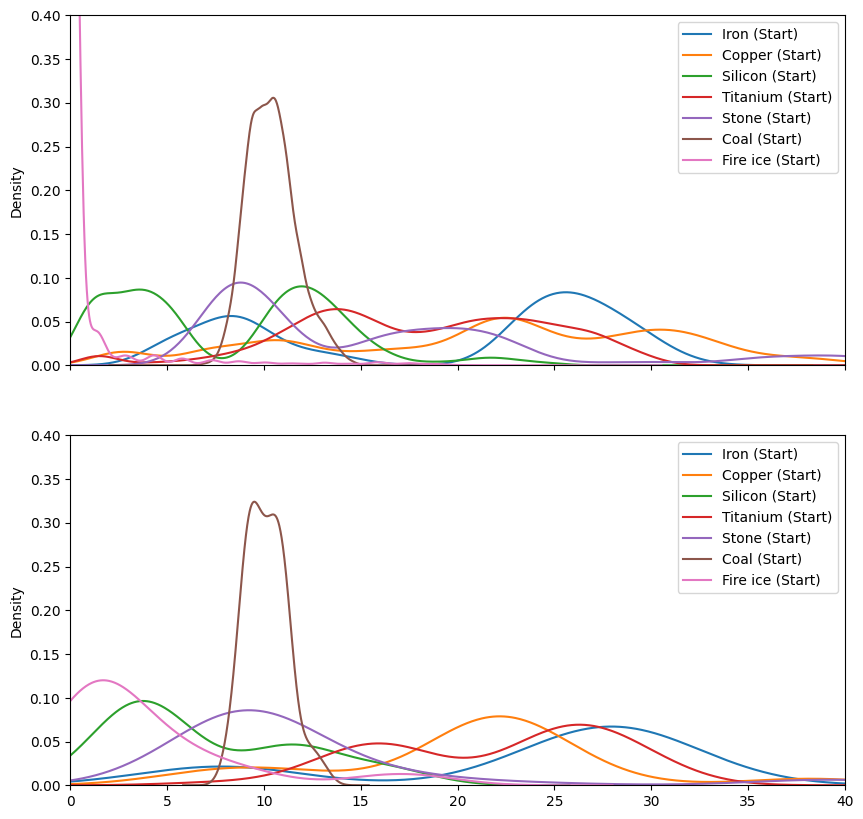

In [19]:
fig, axs = plt.subplots(2, 1, figsize=[10,10], sharex=True, sharey=True)
(seed_res[[x for x in seed_res.columns if 'Start' in x and 'Oil' not in x and 'gas' not in x]] / 1e6).plot.kde(ax=axs[0])
(potential[[x for x in potential.columns if 'Start' in x and 'Oil' not in x and 'gas' not in x]] / 1e6).plot.kde(ax=axs[1])
plt.xlim(0, 40)
plt.ylim(0, .4)


<AxesSubplot: ylabel='Density'>

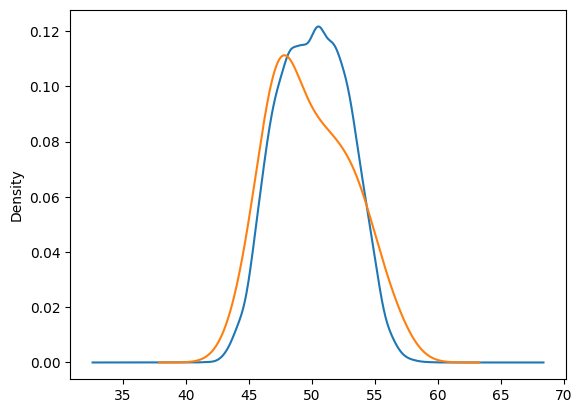

In [20]:
seed_res['Oil (Start)'].plot.kde()
potential['Oil (Start)'].plot.kde()


<AxesSubplot: ylabel='Density'>

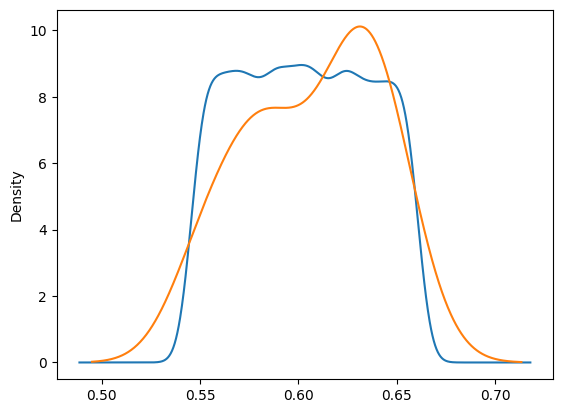

In [21]:
seed_res.query('`Fire ice gas (Start)` > 0')['Fire ice gas (Start)'].plot.kde()
potential.query('`Fire ice gas (Start)` > 0')['Fire ice gas (Start)'].plot.kde()

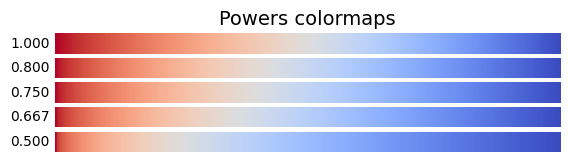

In [22]:
cmap = mpl.cm.get_cmap('coolwarm_r')

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, power_list):
    nrows = len(power_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, power in zip(axs, power_list):
        ax.imshow(gradient ** power, aspect='auto', cmap=cmap)
        ax.text(-.01, .5, '{:.3f}'.format(power), va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

power_list = [1, 4/5, 3/4, 2/3, 1/2]
plot_color_gradients('Powers', power_list)


In [23]:
planet_df.groupby(['seed', 'star'])['planet'].count().describe()

count    856704.000000
mean          3.814427
std           1.327624
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: planet, dtype: float64

In [24]:
star_df.groupby('seed')['star'].count().describe()

count    13386.0
mean        64.0
std          0.0
min         64.0
25%         64.0
50%         64.0
75%         64.0
max         64.0
Name: star, dtype: float64